<a href="https://colab.research.google.com/github/alechfho/timeseries-lab/blob/main/fbprophet_bike_share.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Timeseries Lab

- Provide a light weight introduction to Time series
- Introduction to 2 time series models

## Time series

For typcial ML problems, when we make a prediction about a new observation, that model is built from hundreds or thousands of previous observations that are either all captured at a single point in time, or from data points in which time does not matter. This is known as cross-sectional data.

For example, for future house prices in a neighbourhood, we may take a bunch of data points about rooms, renovation state, age etc at different times and train a model to predict future prices. The data may be collected at different time points but the time element and ordering is not important in the model.

Time series data is different because it is recorded at regular time intervals, and the order of these data points is important. Therefore, any predictive model based on time series data will have time as an independent variable. The output of a model would be the predicted value or classification at a specific future time **based on a value or values in the past**. 

Here are a few examples of how different industries use time series forecasting: 

- Energy – Prices; demand; production schedules
- Retail – Sales; consumer demand for certain products
- State government – Sales tax receipts
- Transportation – Demand for future travel
- Finance – Stocks; market potential


## Example time series

https://www.kaggle.com/chirag19/air-passengers

<img src="airline_passengers.png"/>

A useful abstraction for selecting forecasting methods is to break a time series down into systematic and unsystematic components.

- Systematic: Components of the time series that have consistency or recurrence and can be described and modeled.
- Non-Systematic: Components of the time series that cannot be directly modeled.

A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

- **Trend**: The increasing or decreasing value in the series.
- **Seasonality**: The repeating short-term cycle in the series. 
- **Level**: The average value in the series.

- **Noise (Random)**: The random variation in the series.

<img src="decomposed_airline_passengers.png"/>

Other important concepts that you hear:

- **Stationarity** Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations. When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary to be effective
 


We will look at a couple of models for time series forecasting:

- **ARIMA**
- **Facebook Prophet**

They take 2 very different approaches for modeling timeseries

### ARIMA model

This is a statistical model for analyzing and forecasting time series data. It is composed of 2 timeseries models - Autoregression and Moving Average. Autoregression models the dependent relationship between an observation and some number of lagged observations i.e. the value at time *t+1* has some dependency on the value at time *t*. Moving Average uses a moving average and applies a model to the residual error between the moving average and the actual value observed at time *t*.


### FB Prophet model

This is a model developed by FaceBook and is based on generalized additive model. The approach uses a curve fitting model plus trends, seasonality and typical events such as public holidays that affect the timeseries. 

We will go into more detail in the following sections.


In [2]:
# !pip install numpy pandas pystan fbprophet plotly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

%matplotlib inline
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

In [3]:
# 7 days
validation_set_size = 7*24 
# 3 days
prediction_set_size = 3*24

# About the data

Last year, ML group focused on learning about timeseries forecasting and in the fall of last year, we had an friendly internal competition to see who can use the technique we learnt best. The data we chose to use for the competition was publicly available data from https://bikesharetoronto.com/. 

## Facts about the data
- Every 15 minutes, we collected data from a REST API that list the bike availability by stations throughout Toronto. - There are over 600 stations. Each station is represented by a station id. 
- The data spans October 2020 and Thanksgiving October 12 last year. This tutorial is based on the bike share data.
- The data is aggregated over a month and so each row is denormalized i.e. keyed by last_updated (date) and station_id.

## First steps

- Read in the bike share data from a parquet file
- Set the index to the 'last_updated' and 'station_id' columns


In [4]:
bike_share_df = pd.read_parquet('https://github.com/alechfho/timeseries-lab/raw/main/data/all_data.parquet.gzip')

bike_share_df['last_updated'] = pd.to_datetime(bike_share_df['last_updated'] * 1000, unit='ms')
bike_share_df = bike_share_df.set_index(['last_updated', 'station_id'])
bike_share_df.head()

num_bikes_available
last_updated        station_id                     
2020-10-04 20:11:46 7000                         17
                    7001                          4
                    7002                          7
                    7003                          0
                    7004                          3

- 'Unstack' the index so that everything is keyed by date and the station_id are now columns

In [5]:
bike_share_stations_df = bike_share_df.unstack()

bike_share_stations_df.head()

num_bikes_available                                      \
station_id                         7000 7001 7002 7003 7004  7005 7006 7007   
last_updated                                                                  
2020-10-04 20:11:46                17.0  4.0  7.0  0.0  3.0  11.0  6.0  6.0   
2020-10-04 20:14:54                17.0  4.0  7.0  0.0  3.0  11.0  6.0  6.0   
2020-10-04 20:30:00                17.0  5.0  7.0  1.0  3.0  11.0  4.0  6.0   
2020-10-04 20:45:03                15.0  5.0  7.0  1.0  3.0  12.0  3.0  6.0   
2020-10-04 20:59:44                15.0  5.0  6.0  2.0  3.0  12.0  7.0  6.0   

                                ...                                           \
station_id          7008  7009  ... 7650 7651  7653 7654 7655 7656 7657 7658   
last_updated                    ...                                            
2020-10-04 20:11:46  7.0  13.0  ...  4.0  3.0  10.0  3.0  2.0  1.0  8.0  5.0   
2020-10-04 20:14:54  7.0  13.0  ...  4.0  3.0  10.0  3.0  2.0  0.0  8.0  5.0   
2020-10-04 20:30:00  7.0  13.0  ...  4.0  3.0  10.0  3.0  2.0  0.0  8.0  5.0   
2020-10-04 20:45:03  7.0  13.0  ...  4.0  2.0  10.0  3.0  2.0  0.0  9.0  5.0   
2020-10-04 20:59:44  7.0  13.0  ...  4.0  2.0  10.0  3.0  2.0  0.0  9.0  5.0   

                               
station_id          7659 7660  
last_updated                   
2020-10-04 20:11:46  NaN  NaN  
2020-10-04 20:14:54  NaN  NaN  
2020-10-04 20:30:00  NaN  NaN  
2020-10-04 20:45:03  NaN  NaN  
2020-10-04 20:59:44  NaN  NaN  

[5 rows x 607 columns]

- The data is at 15 minutes interval and is very fine grain. Let's reduce the timescale to every hour since we will be predicting based on the hour.

- Note that here we chose to resample using group by max value. We could have chosen other methods as well.
- **Exercise: Look up other time scale**
- **Exercise: Look up other groupby methods**

In [6]:
bike_share_stations_df_1h = bike_share_stations_df.resample('1h').max()

bike_share_stations_df_1h.head()

num_bikes_available                                        \
station_id                         7000  7001 7002 7003 7004  7005  7006 7007   
last_updated                                                                    
2020-10-04 20:00:00                17.0   5.0  7.0  2.0  3.0  12.0   7.0  6.0   
2020-10-04 21:00:00                17.0   7.0  5.0  1.0  4.0  12.0   9.0  5.0   
2020-10-04 22:00:00                18.0   8.0  5.0  1.0  5.0  15.0  11.0  5.0   
2020-10-04 23:00:00                20.0  10.0  5.0  3.0  5.0  16.0  11.0  5.0   
2020-10-05 00:00:00                22.0  12.0  5.0  3.0  4.0  16.0  11.0  4.0   

                                ...                                           \
station_id          7008  7009  ... 7650 7651  7653 7654 7655 7656 7657 7658   
last_updated                    ...                                            
2020-10-04 20:00:00  7.0  13.0  ...  4.0  3.0  10.0  3.0  2.0  1.0  9.0  5.0   
2020-10-04 21:00:00  7.0  14.0  ...  5.0  2.0  10.0  3.0  2.0  0.0  9.0  5.0   
2020-10-04 22:00:00  7.0  15.0  ...  5.0  2.0  10.0  3.0  2.0  0.0  9.0  5.0   
2020-10-04 23:00:00  8.0  13.0  ...  5.0  2.0   9.0  2.0  2.0  0.0  9.0  5.0   
2020-10-05 00:00:00  8.0  13.0  ...  5.0  2.0   9.0  2.0  2.0  0.0  7.0  5.0   

                               
station_id          7659 7660  
last_updated                   
2020-10-04 20:00:00  NaN  NaN  
2020-10-04 21:00:00  NaN  NaN  
2020-10-04 22:00:00  NaN  NaN  
2020-10-04 23:00:00  NaN  NaN  
2020-10-05 00:00:00  NaN  NaN  

[5 rows x 607 columns]

We will work with one specific station **Bay and Wellesley - station id 7030**

In [7]:
df_7030 = bike_share_stations_df_1h['num_bikes_available']['7030'].to_frame()
# can we get rid of df_7030?
df = bike_share_stations_df_1h['num_bikes_available']['7030'].to_frame()

# Why FB Prophet

* Building classical time series models may be quite involved and is not getting as much love as other ML approaches 
* Forecasting, a common business problem, needed a tool that is more accessible and doesn't require as much expertise
* Opportunity to build a tool (not all purpose, but) that can be applied in many scenarios like capacity planning, how many users, how fast will the data grow, forecasting number of bugs (translated to staffing) or other like anomaly detection

# How

* Identifying common usecases and typical time series data sets, covering them with minimal configuration that lets users apply their business knowledge (allowing for further tweaking and advanced features if needed)
* A tool that can cover seasonality, holiday effect, piecewise trends - characteristic to time series describing "people doing things"
* Building on top of Stan widely used statistical language software package, applied in social science, pharmaceutical statistics, market research

# Other characteristics
* Decomposable model that can be explained - insights on the level of individual components
* Fast - practical in quick iterations when building a model 

# Prepare for Prophet

For prophet to work, we need to change the names of these columns to 'ds' and 'y', so lets just create a new dataframe and keep our old one handy (you'll see why later). The new dataframe will initially be created with an integer index so we can rename the columns

https://facebook.github.io/prophet/docs/quick_start.html

The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [8]:
df = df.reset_index()
df = df.rename(columns={'last_updated':'ds', '7030':'y'})

In [9]:
df.head(10)

,ds,y
0,2020-10-04 20:00:00,32.0
1,2020-10-04 21:00:00,31.0
2,2020-10-04 22:00:00,30.0
3,2020-10-04 23:00:00,32.0
4,2020-10-05 00:00:00,30.0
5,2020-10-05 01:00:00,28.0
6,2020-10-05 02:00:00,28.0
7,2020-10-05 03:00:00,44.0
8,2020-10-05 04:00:00,45.0
9,2020-10-05 05:00:00,45.0


Now's a good time to take a look at your data.  Plot the data using pandas' ```plot``` function

<AxesSubplot:xlabel='ds'>

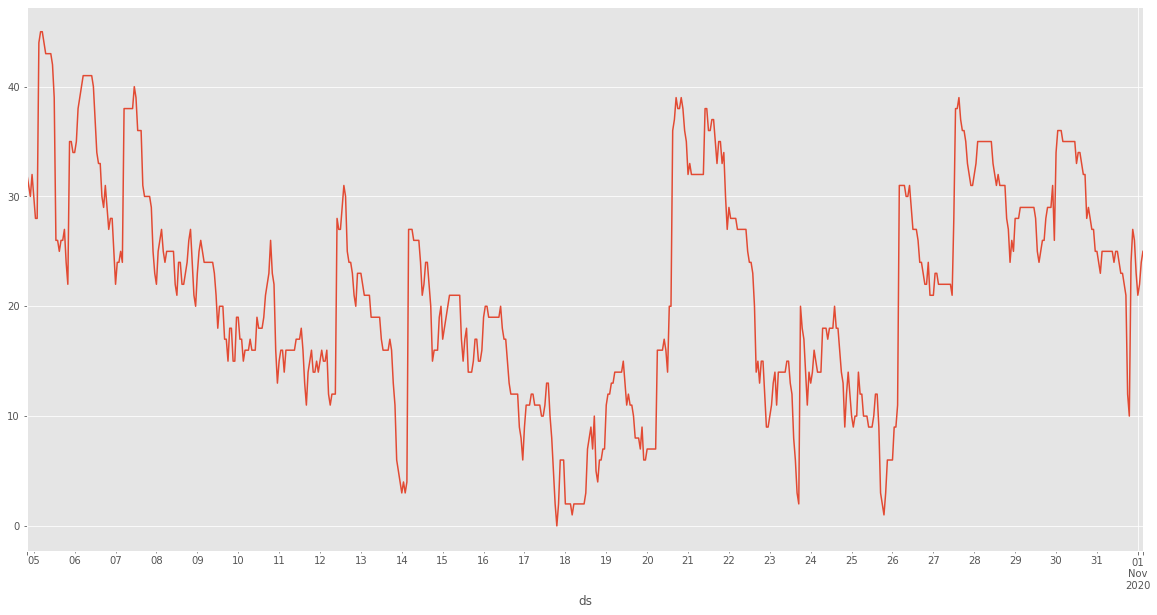

In [10]:
df.set_index('ds').y.plot()

When working with time-series data, its good to take a look at the data to determine if trends exist, whether it is stationary, has any outliers and/or any other anamolies. Facebook prophet's example uses the log-transform as a way to remove some of these anomolies but it isn't the absolute 'best' way to do this...but given that its the example and a simple data series, I'll follow their lead for now.  Taking the log of a number is easily reversible to be able to see your original data. 

To log-transform your data, you can use numpy's log() function

In this case, we don't see a trend but do see a daily cycle. One strategy is to apply a log transform:

    df['y'] = np.log(df['y'])

For timeseries data, this is referred to as seasonality.

# Running Prophet

Now, let's set prophet up to begin modeling our data.

Since we are working with daily data, we are turning on daily_seasonality.

In [11]:
model = Prophet(yearly_seasonality=False, daily_seasonality=True, 
                n_changepoints=10, changepoint_range=0.99, changepoint_prior_scale=0.3)
model.add_country_holidays(country_name='CA')
model.fit(df);

Since we're forecasting 8 hours into the future, we set the ```freq='h'``` and set the period to 8.


In [12]:
future = model.make_future_dataframe(periods=8, freq = 'h')
future.tail()

,ds
659,2020-11-01 07:00:00
660,2020-11-01 08:00:00
661,2020-11-01 09:00:00
662,2020-11-01 10:00:00
663,2020-11-01 11:00:00


### Account for holidays

https://github.com/dr-prodigy/python-holidays

In [13]:
model.train_holiday_names

0           New Year's Day
1              Good Friday
2             Victoria Day
3               Canada Day
4               Labour Day
5             Thanksgiving
6          Remembrance Day
7            Christmas Day
8    Boxing Day (Observed)
dtype: object

To forecast this future data, we need to run it through Prophet's model by calling the ```fit``` method

In [14]:

forecast = model.predict(future)


The resulting forecast dataframe contains quite a bit of data, but we really only care about a few columns.  First, let's look at the full dataframe:

In [15]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Boxing Day (Observed),Boxing Day (Observed)_lower,Boxing Day (Observed)_upper,Canada Day,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
659,2020-11-01 07:00:00,31.571817,19.178293,32.493070,31.571817,31.571817,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-7.168150,-7.168150,-7.168150,0.0,0.0,0.0,26.146691
660,2020-11-01 08:00:00,31.641605,20.160602,33.104132,31.641605,31.641605,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-7.129682,-7.129682,-7.129682,0.0,0.0,0.0,26.419635
661,2020-11-01 09:00:00,31.711393,20.051048,33.612050,31.711393,31.711393,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-7.071291,-7.071291,-7.071291,0.0,0.0,0.0,26.622660
662,2020-11-01 10:00:00,31.781182,20.102528,33.431291,31.781182,31.781182,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-6.993856,-6.993856,-6.993856,0.0,0.0,0.0,26.697806
663,2020-11-01 11:00:00,31.850970,19.434270,33.363914,31.850970,31.850970,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-6.898397,-6.898397,-6.898397,0.0,0.0,0.0,26.682899


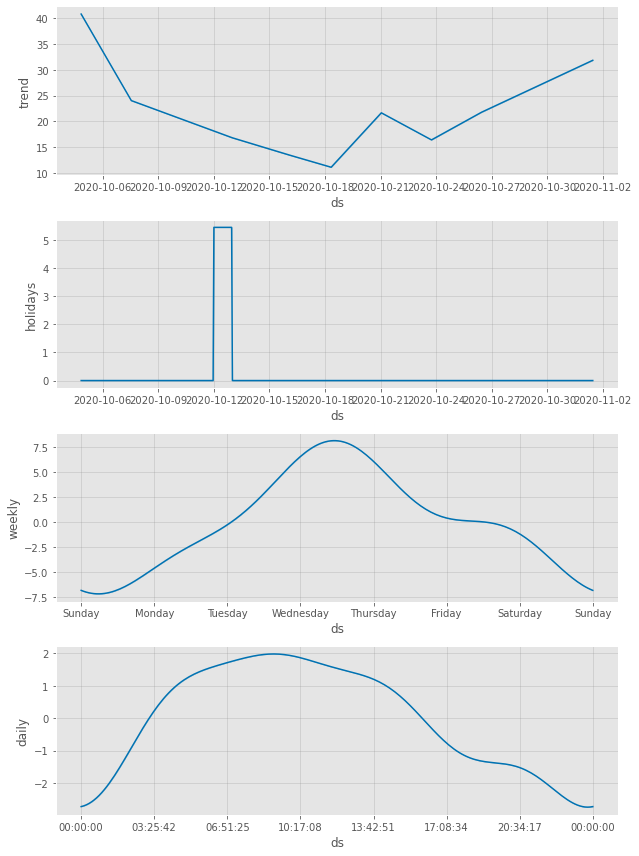

In [16]:
model.plot_components(forecast);

# Plotting Prophet results

Prophet has a plotting mechanism called ```plot```.  This plot functionality draws the original data (black dots), the model (blue line) and the error of the forecast (shaded blue area).

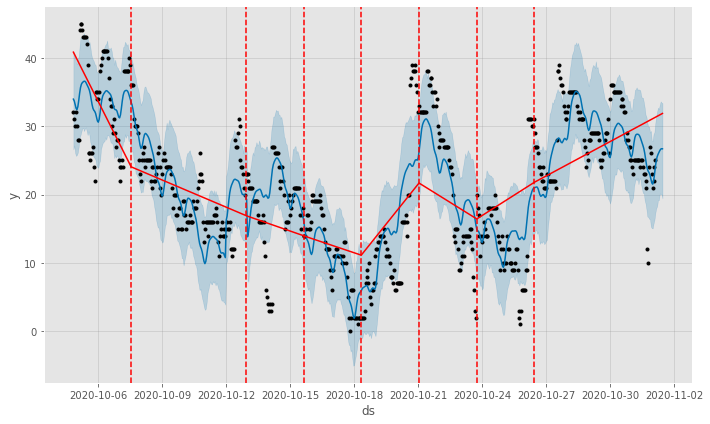

In [17]:
fig = model.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), model, forecast)

**Exercise: experiment with the trend using changepoint parameters**

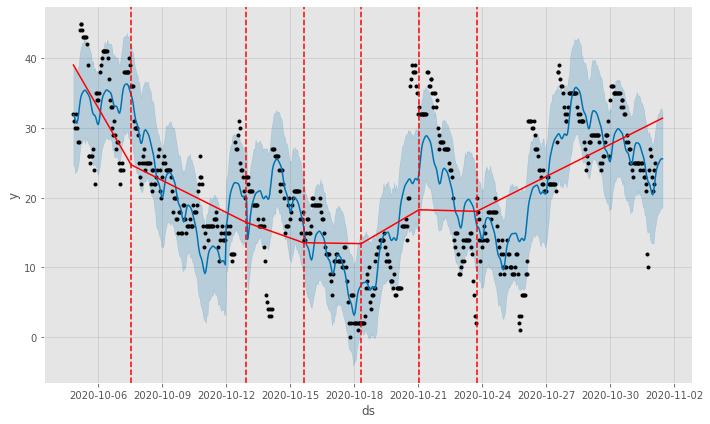

In [18]:
model2 = Prophet(yearly_seasonality=False, daily_seasonality=True, 
                 n_changepoints=10, changepoint_range=0.99, changepoint_prior_scale=0.2)
model2.add_country_holidays(country_name='CA')
model2.fit(df);
forecast2 = model2.predict(model2.make_future_dataframe(periods=8, freq = 'h'))
fig2 = model2.plot(forecast2);
add_changepoints_to_plot(fig2.gca(), model2, forecast2);

The next section describes how we can build another visualization for Prophet modeling 

# Visualizing Prophet models

In order to build a useful dataframe to visualize our model versus our original data, we need to combine the output of the Prophet model with our original data set, then we'll build a new chart manually using pandas and matplotlib.

First, let's set our dataframes to have the same index of ```ds```

In [19]:
vdf = df.set_index('ds')
forecast.set_index('ds', inplace=True)

Now, we'll combine the original data and our forecast model data

In [20]:
viz_df = vdf.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

viz_df.head()

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2020-10-04 20:00:00,32.0,33.943061,26.593392,40.938664
2020-10-04 21:00:00,31.0,33.662282,27.171685,40.141230
2020-10-04 22:00:00,30.0,33.149997,26.062459,40.017821
2020-10-04 23:00:00,32.0,32.614425,25.644860,39.274714
2020-10-05 00:00:00,30.0,32.427495,25.801853,39.025819


Let's take a look at the ```y``` and ```yhat``` data together in a chart.

<AxesSubplot:xlabel='ds'>

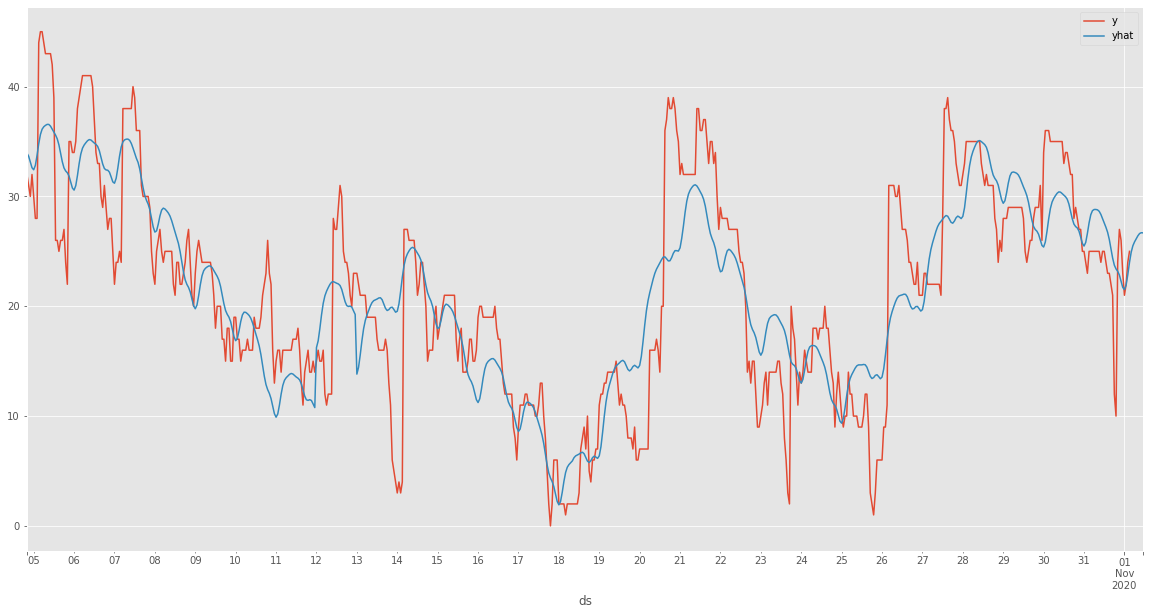

In [21]:
viz_df[['y', 'yhat']].plot()

# Comparison with statistical model (ARIMA)
ARIMA (Autoregressive Integrated Moving Average Model, or ARIMA for short is a standard statistical model for time series forecast and analysis.

### Import packages 
[statsmodels](https://www.statsmodels.org/stable/index.html) is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. 

[sklearn.metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) module includes score functions, performance metrics, pairwise metrics and distance computations. 

In [22]:
#!pip install sklearn
#!pip install --upgrade git+https://github.com/statsmodels/statsmodels
    
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

## ARIMA model and parameters
An ARIMA model is a class of statistical models for analyzing and forecasting time series data. ARIMA is an acronym that stands for Auto Regressive Integrated Moving Average. 

#### Key aspects of the model are:

- **AR: *Autoregression.***
 A model that uses the dependent relationship between an observation and some number of lagged observations. 

    An autoregression model makes an assumption that the observations at current and previous time steps are useful to predict the value at the next time step. We can use statistical measures to calculate the correlation between the output variable and values at previous time steps at various different lags. 
    
    The stronger the correlation between the output variable and a specified lag variable, the more weight that autoregression model can put on that variable when modeling. Because the correlation is calculated between the variable and itself at previous time steps, it is called an autocorrelation. 
    
    For example, consective values in the Google stock prices appear to follow one another fairly closely:
    
    <img src="autoregression_google_stock.png" />
    <center>Source: https://online.stat.psu.edu/stat501/lesson/14/14.1</center>
    
    Partial autocorrelation graph for stock prices shows that there is a significant spike at a lag of 1 and much lower spikes for the subsequent lags:
    
    <img src="autocorrelation_google_stock.png" />
    <center>Source: https://online.stat.psu.edu/stat501/lesson/14/14.1</center>
    <br>
    
- **I: *Integrated.***
The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

    For example, the plot of antidiabetic drug sales time series shows that it has an increasing trend, strong seasonality, and increasing variation. Transformations such as logarithms can help to stabilize the variance of a time series. Differencing can help stabilize the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality. 
    
    <img src="differencing_antidiabetic_drugs.png" width="700"/>
    <center>Source: http://course1.winona.edu/bdeppa/FIN%20335/Handouts/ARIMA_Part_1.html</center>

    <br>
- **MA: *Moving Average.***
A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. 

    The difference between what was expected and what was predicted is called residual error. Just like the input observations, residual errors form a time series and can have temporal structure like trends, bias and seasonality. A simple and effective model of residual error is autoregression. Some number of lagged error values are used to predict the error at the next time step. The predict errors are used to correct forecasts. 
    > *improved forecast = forecast + estimated error*
    
    An autoregression of the residual error time series is called a Moving Average (MA) model. It has nothing to do with the moving average smoothing process.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

#### The parameters of the ARIMA model are defined as follows:

- **p**: The number of lag observations included in the model, also called the lag order.
- **d**: The number of times that the raw observations are differenced, also called the degree of differencing.
- **q**: The size of the moving average window, also called the order of moving average.

## Step 1 - Grid Search 
Grid search is the process of training and evaluating models on different combinations of model hyperparameters. In machine learning, a hyperparameter is a parameter whose value is used to control the learning process. By contrast, the values of other parameters (typically node weights) are derived via training.

ARIMA model for time series forecasting can be tricky to configure. We will evaluate ARIMA model using different combinations of (p, d, q) and find the one with the best score i.e. minimum mean squared error on the validation set.

In [23]:
# Hourly data points
arima_dataset = df_7030["7030"]
arima_train = arima_dataset[1:len(arima_dataset) - prediction_set_size]
arima_train.head()

last_updated
2020-10-04 21:00:00    31.0
2020-10-04 22:00:00    30.0
2020-10-04 23:00:00    32.0
2020-10-05 00:00:00    30.0
2020-10-05 01:00:00    28.0
Freq: H, Name: 7030, dtype: float64

#### Helper function to evaluate arima model

In [24]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train, validation = X[1:len(X) - validation_set_size], X[len(X)-validation_set_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(validation)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(validation[t])
    # calculate out-of-sample error
    rmse = sqrt(mean_squared_error(validation, predictions))
    return rmse

#### Helper function to interate over different combinations of parameters and evaluate ARIMA model

In [25]:
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order, rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

#### Evaluate ARIMA model with different combinations of p, d, and q values
This can take a 5-10 minutes to finish. So be patient!

In [ ]:
p_values = range(20, 30) # lag observations
d_values = range(0, 3) # Number of times raw observations are differenced
q_values = range(0, 3) # Size of moving average window

evaluate_models(arima_train, p_values, d_values, q_values)

## Step 2 - Predictions using best ARIMA parameters
Using the best paramters for ARIMA, make predictions 8 hours into the future.

### Helper function to make predictions using ARIMA model and given parameters

In [26]:
def make_predictions(dataset, order, number_of_predictions):
    history = [x for x in dataset]
    predictions = list()
    for t in range(number_of_predictions):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(yhat)
        print('prediction-%d= %f' % (t+1, yhat))
    return predictions

In [27]:
# EXERCISE: Update arima_order to different values of p,d,q and make predictions
# Also rerun Step 3 code in the next section to replot using the latest predictions
arima_order = (29, 2, 0)

arima_predictions = make_predictions(arima_train, arima_order, prediction_set_size)
arima_predictions_date_range = pd.date_range(arima_train.last_valid_index(), periods=prediction_set_size, freq='H')
arima_predictions_df = pd.DataFrame({'last_updated': arima_predictions_date_range, 'yhat_arima':arima_predictions})
arima_predictions_df = arima_predictions_df.set_index('last_updated')
arima_predictions_df

prediction-1= 28.738048
prediction-2= 29.085723
prediction-3= 29.052576
prediction-4= 29.325391
prediction-5= 29.092399
prediction-6= 28.927165
prediction-7= 28.550046
prediction-8= 28.181133
prediction-9= 27.557060
prediction-10= 27.242883
prediction-11= 26.680230
prediction-12= 26.213953
prediction-13= 25.819136
prediction-14= 25.517030
prediction-15= 25.418195
prediction-16= 24.858782
prediction-17= 24.513772
prediction-18= 24.331591
prediction-19= 24.219677
prediction-20= 24.170771
prediction-21= 24.009451
prediction-22= 23.767168
prediction-23= 23.561810
prediction-24= 23.511552
prediction-25= 23.812957
prediction-26= 23.734190
prediction-27= 23.897341
prediction-28= 23.832642
prediction-29= 23.660549
prediction-30= 23.536004
prediction-31= 23.336107
prediction-32= 23.165197
prediction-33= 22.901616
prediction-34= 22.636350
prediction-35= 22.316465
prediction-36= 22.004705
prediction-37= 21.718140
prediction-38= 21.460420
prediction-39= 21.173161
prediction-40= 20.895145
predictio

,yhat_arima
last_updated,
2020-10-29 03:00:00,28.738048
2020-10-29 04:00:00,29.085723
2020-10-29 05:00:00,29.052576
2020-10-29 06:00:00,29.325391
2020-10-29 07:00:00,29.092399
...,...
2020-10-31 22:00:00,15.932285
2020-10-31 23:00:00,15.744995
2020-11-01 00:00:00,15.570147


## Step 3 - Plot predictions from both models
Plot bike share training dataset and predictions generated by ARIMA model and Prophet

<AxesSubplot:>

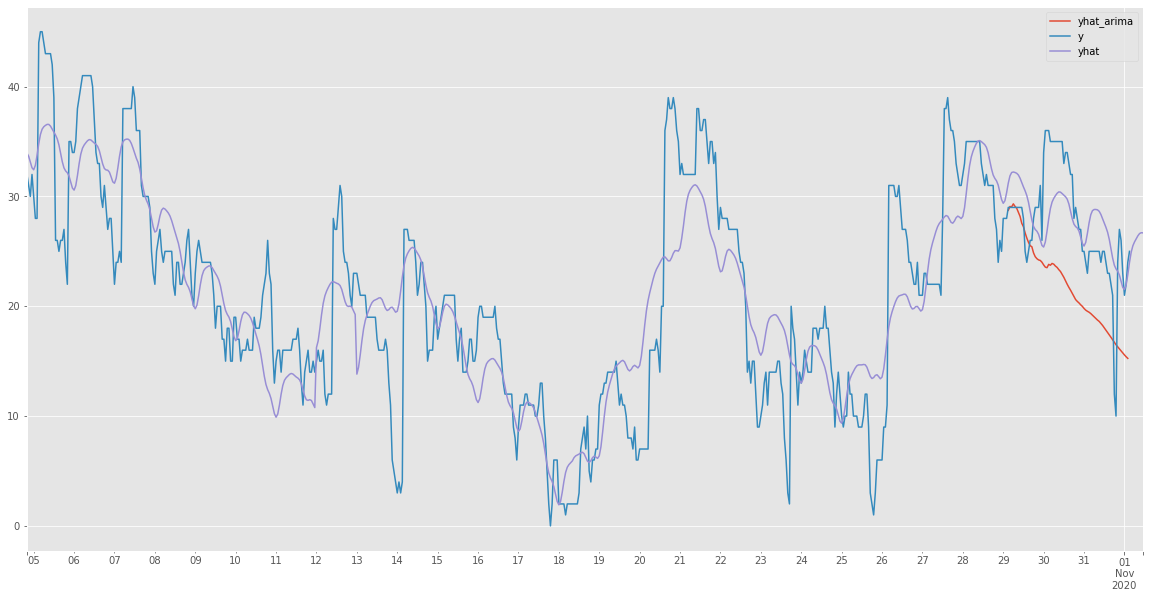

In [30]:
# EXERCISE: Change number of days to show to 21 days, and then 14 days, and then 7 days
number_of_days_to_show = 28
comparison_df = arima_predictions_df.join(viz_df[['y', 'yhat']], how = 'outer').tail(24*number_of_days_to_show)
comparison_df.plot()

Plot of ARIMA predictions (Zoomed in)

<AxesSubplot:>

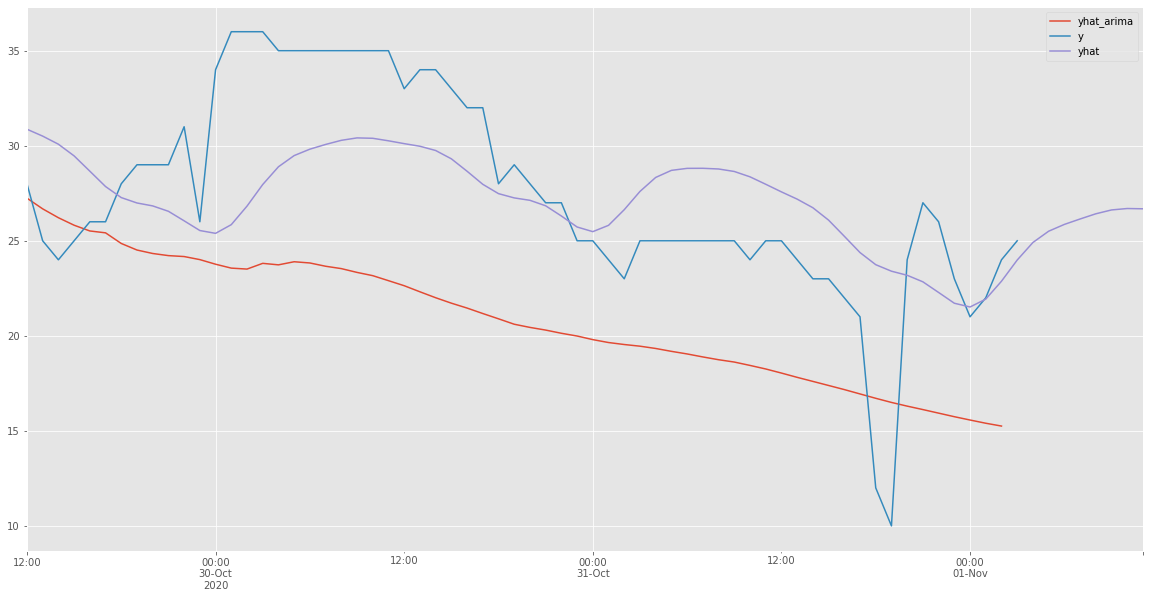

In [31]:
comparison_df_predictions_only = arima_predictions_df.join(viz_df[['y', 'yhat']], how = 'outer').tail(prediction_set_size)
comparison_df_predictions_only.plot()

## References
- [Introduction to Time Series Forecasting with Python - Jason Brownlee](https://machinelearningmastery.com/introduction-to-time-series-forecasting-with-python/)
- [STAT501 - Penn State](https://online.stat.psu.edu/stat501)
- [ARIMA Models - Rob Hyndman](http://course1.winona.edu/bdeppa/FIN%20335/Handouts/ARIMA_Part_1.html)